# **Machine Learning Techniques Project**


*   Nicolas Bedoya Figueroa
*   Daniel Escalante Perez
*   Marilyn Stephany Joven Fonseca
*   Eder Leandro Carbonero Baquero

## **Utils**

In [1]:
!pip install nltk pyspellchecker tqdm emoji nlpaug transformers tensorflow xgboost[gpu] accelerate

In [2]:
!pip install seaborn transformers torch tqdm 

In [3]:
!pip install umap-learn plotly

In [4]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import emoji
import random
import math
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

2025-05-11 21:14:47.083144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 21:14:47.090443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747016087.098687   16940 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747016087.101226   16940 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747016087.107738   16940 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

True

Librerias ML y DL

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import umap
import plotly.express as px
import ast
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
import random
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
random_seed = 611
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

## **Data preprocessing**

### **Dataset 1: Davidson et al. 2017**

In [6]:
# Load the dataset
davidson = pd.read_csv("./data/davidson_2017.csv")[["class", "tweet"]]
davidson.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# Original class labels: 0 - hate speech, 1 - offensive language, 2 - neither
# Transform the label in 1: toxic and 0: non toxic
davidson["class"] = davidson["class"].replace({0: 1, 2: 0})
davidson["class"].value_counts()

class
1    20620
0     4163
Name: count, dtype: int64

In [8]:
print("Rows:", davidson.shape[0])
print("Columns:", davidson.shape[1])

Rows: 24783
Columns: 2


### **Dataset 2: HASOC (2019) English**

In [9]:
hasoc = pd.read_csv("./data/HASOC_EN.tsv",sep = '\t')[["text","task_1"]]
hasoc.head()

,text,task_1
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT
1,@politico No. We should remember very clearly ...,HOF
2,@cricketworldcup Guess who would be the winner...,NOT
3,Corbyn is too politically intellectual for #Bo...,NOT
4,All the best to #TeamIndia for another swimmin...,NOT


In [10]:
# Transform the label to 1: toxic and 0: non toxic
hasoc["task_1"] = hasoc["task_1"].replace({"HOF": 1, "NOT": 0})
hasoc["task_1"].value_counts()

/tmp/ipykernel_20878/1216868155.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hasoc["task_1"] = hasoc["task_1"].replace({"HOF": 1, "NOT": 0})


task_1
0    3591
1    2261
Name: count, dtype: int64

In [11]:
# Change column names to match the other datasets
hasoc = hasoc.rename(columns={'task_1': 'class', 'text': 'tweet'})
hasoc.head()

,tweet,class
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,0
1,@politico No. We should remember very clearly ...,1
2,@cricketworldcup Guess who would be the winner...,0
3,Corbyn is too politically intellectual for #Bo...,0
4,All the best to #TeamIndia for another swimmin...,0


In [12]:
print("Rows:", hasoc.shape[0])
print("Columns:", hasoc.shape[1])

Rows: 5852
Columns: 2


### **Dataset 3: Zeerak Talat’s Hate Speech Dataset**

In [13]:
# Load the dataset
zeerak = pd.read_csv("./data/NAACL_SRW_2016_fixed.csv")[["class", "text"]]
zeerak.head()

,class,text
0,racism,So Drasko just said he was impressed the girls...
1,racism,Drasko they didn't cook half a bird you idiot ...
2,racism,Hopefully someone cooks Drasko in the next ep ...
3,racism,of course you were born in serbia...you're as ...
4,racism,RT @YesYoureRacist: At least you're only a tin...


In [14]:
# Original class labels
zeerak["class"].value_counts()

class
none      7060
sexism    2577
racism      11
Name: count, dtype: int64

In [15]:
# Transform the label to 1: toxic and 0: non toxic
zeerak["class"] = zeerak["class"].replace({"sexism": 1, "racism": 1, "none": 0})
zeerak["class"].value_counts()

/tmp/ipykernel_20878/990906760.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  zeerak["class"] = zeerak["class"].replace({"sexism": 1, "racism": 1, "none": 0})


class
0    7060
1    2588
Name: count, dtype: int64

In [16]:
# Rename the columns to match the other datasets
zeerak = zeerak.rename(columns={'text': 'tweet'})
zeerak.head()

,class,tweet
0,1,So Drasko just said he was impressed the girls...
1,1,Drasko they didn't cook half a bird you idiot ...
2,1,Hopefully someone cooks Drasko in the next ep ...
3,1,of course you were born in serbia...you're as ...
4,1,RT @YesYoureRacist: At least you're only a tin...


In [17]:
print("Rows:", zeerak.shape[0])
print("Columns:", zeerak.shape[1])

Rows: 9648
Columns: 2


### **Concatenation**

In [18]:
data = pd.concat([davidson, hasoc, zeerak], axis=0, ignore_index=True)
data.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [19]:
data["class"].value_counts()

class
1    25469
0    14814
Name: count, dtype: int64

In [20]:
print("Rows:", data.shape[0])
print("Columns:", data.shape[1])

Rows: 40283
Columns: 2


### **Cleaning**

In [21]:
#Check point
# Creation of one dataset for embedding of text into a vector and another one for embbeding with GloVe + Twitter
data_cleaning = data.copy()
data_cleaning_slight = data.copy()

In [22]:
# Transform emojis into words

def emoji_to_words(text):
  return emoji.demojize(text, language='en')

data_cleaning['tweet'] = data_cleaning['tweet'].apply(emoji_to_words)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(emoji_to_words)

In [23]:
# Remove URLs from tweets

def remove_urls(text):
  return re.sub(r'http\S+', '', text)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_urls)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(remove_urls)

In [24]:
# Remove mentions from tweets
def remove_mentions(text):
  return re.sub(r'@\w+', '', text)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_mentions)


In [25]:
# Remove symbols from tweets

def leave_letters(text):
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

data_cleaning['tweet'] = data_cleaning['tweet'].apply(leave_letters)

In [26]:
# Remove uncommon symbols from tweets

def clean_tweet_for_glove(text):
  # Keep only letters, numbers, hashtags, mentions, apostrophes, emojis, and basic punctuation
  text = re.sub(r"[^a-zA-Z0-9@#'’!?.,\s]", '', text)  # keep @, #, apostrophes, basic punctuation
  text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with single space
  return text.strip()

data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(clean_tweet_for_glove)

In [27]:
# Remove symbols from tweets

def lowercase(text):
  return text.lower()

data_cleaning['tweet'] = data_cleaning['tweet'].apply(lowercase)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(lowercase)

In [28]:
# Correct spelling
spell = SpellChecker()

def correct_spelling(text):
  words = text.split()
  corrected_words = [spell.correction(word) or word for word in words]
  return ' '.join(corrected_words)

data_cleaning['tweet'] = [correct_spelling(text) for text in tqdm(data_cleaning['tweet'])]

100%|███████████████████████████████████████████████████████████████████████████████████████| 40283/40283 [2:47:53<00:00,  4.00it/s]


In [29]:
# Remove stopwords

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))  # Use English stop words
  words = text.split()
  filtered_words = [word for word in words if word not in stop_words]
  return " ".join(filtered_words)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_stopwords)

In [30]:
# Stemming the words

stemmer = PorterStemmer()

def stem_text(text):
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  return " ".join(stemmed_words)

  data_cleaning['tweet'] = data_cleaning['tweet'].apply(stem_text)


In [31]:
data_cleaning['tweet'].head(200)

0      woman complain cleaning house amp man always t...
1             boy days cold toga bad coffin hoe st place
2           dawn ever fuck bitch start cry confused shit
3                                       look like granny
4         shit hear might true might faker bitch told ya
                             ...                        
195    tired bitches saying look mean night big af we...
196    birds grandads may never see thanks climate ch...
197                                 stay beautiful bitch
198    wutkinda r purple ceeeleee man girl playing st...
199          money getting taller bitches getting blurry
Name: tweet, Length: 200, dtype: object

In [32]:
data_cleaning_slight['tweet'].head(200)

0      !!! rt @mayasolovely as a woman you shouldn't ...
1      !!!!! rt @mleew17 boy dats cold...tyga dwn bad...
2      !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3      !!!!!!!!! rt @cganderson @vivabased she look l...
4      !!!!!!!!!!!!! rt @shenikaroberts the shit you ...
                             ...                        
195    @montrell i'm tired of bitches saying i look m...
196    @motherjones 10 birds your grandkids may never...
197                 @mvckfadden stay beautiful you bitch
198    @nickiminaj #wutkinda r purple. ceeeleeeman th...
199    @nastycopper money getting taller and bitches ...
Name: tweet, Length: 200, dtype: object

In [33]:
# Check and remove duplicates
def check_remove_dup(dataset):
  print(f'Duplicates: {dataset["tweet"].duplicated().sum()}')
  duplicated_tweets = dataset["tweet"].duplicated()
  return dataset[~duplicated_tweets]

In [34]:
# Check and remove duplicates in the first dataset

data_cleaning = check_remove_dup(data_cleaning)

Duplicates: 1823


In [35]:
# Check and remove duplicates in the second dataset

data_cleaning_slight = check_remove_dup(data_cleaning_slight)


Duplicates: 185


In [36]:
# Check for null or empty 

def check_null_empty(dataset):
  keep = ~((dataset["tweet"].isnull()) | (dataset["tweet"] == ""))
    
  print(f'Number of nulls or empty: {(~keep).sum()}')
    
  dataset = dataset[keep]
    
  print(f'Cleaned data shape: {dataset.shape}')

  return dataset

In [37]:
# Check for null or empty in the first dataset

data_cleaning = check_null_empty(data_cleaning)

Number of nulls or empty: 1
Cleaned data shape: (38459, 2)


In [38]:
# Check for null or empty in the second dataset

data_cleaning_slight = check_null_empty(data_cleaning_slight)

Number of nulls or empty: 1
Cleaned data shape: (40097, 2)


In [39]:
# Checking the dataset's balance

data_cleaning["class"].value_counts()

class
1    24345
0    14114
Name: count, dtype: int64

In [40]:
# Checking the dataset's balance

data_cleaning_slight["class"].value_counts()

class
1    25419
0    14678
Name: count, dtype: int64

In [41]:
# Function to get a random synonym of a word

def get_synonym(word):
  synonyms = []
  for syn in wordnet.synsets(word):
    for lemma in syn.lemmas():
      synonyms.append(lemma.name())
  if len(synonyms) > 0:
    synonyms = list(set(synonyms))
    return synonyms[random.randint(0, len(synonyms) - 1)]
  else:
    return ""

In [42]:
# Custom random insertion function

def random_synonym_insert_augment(text, alpha):

  words = text.split()
  new_text = words.copy()
  for word in words:
    if random.random() < alpha:
      synonym = get_synonym(word)
      if synonym != "":
        position = random.randint(0, len(new_text) - 1)
        new_text.insert(position, synonym)

  return [" ".join(new_text)]

In [43]:
# Balance the data set using easy data augmentation

#Choose an alpha parameter (Percentage of words in a sentence that are changed)
alpha = 0.25

aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p = alpha)
aug_swap = naw.RandomWordAug(action="swap", aug_p = alpha)
aug_delete = naw.RandomWordAug(action="delete", aug_p = alpha)


def data_augmentation(dataset, alpha):
  # Store the new rows
  new_rows = []

  # Size to balance the classes
  desired_size = len(dataset[dataset['class'] == 1]) - len(dataset[dataset['class'] == 0])

  non_toxic = dataset[dataset['class'] == 0]

  # Until balanced
  while len(new_rows) < desired_size:
    # Get a random sample from the minority class
    random_row = non_toxic.sample(1)

    # Pick a random EDA technique and apply it
    random_num = random.randint(1, 4)
    augmented_text = []

    if random_num == 1:
      augmented_text = aug_synonym.augment(random_row['tweet'].values[0])
    elif random_num == 2:
      augmented_text = aug_swap.augment(random_row['tweet'].values[0])
    elif random_num == 3:
      augmented_text = random_synonym_insert_augment(random_row['tweet'].values[0], alpha)
    else:
      augmented_text = aug_delete.augment(random_row['tweet'].values[0])

    if len(augmented_text) > 0:
      new_rows.append({ "tweet": augmented_text[0], "class": random_row['class'].values[0] })


  # New rows dataframe
  new_rows_df = pd.DataFrame(new_rows)

  # Concatenate the datasets
  return pd.concat([dataset, new_rows_df], ignore_index = True, axis = 0)

In [44]:
# Balance the first dataset

balanced_data = data_augmentation(data_cleaning, alpha)

print(f'Balanced data shape: {balanced_data.shape}')
print()
balanced_data["class"].value_counts()


Balanced data shape: (48690, 2)



class
0    24345
1    24345
Name: count, dtype: int64

In [45]:
# Balance the second dataset

balanced_data_glove = data_augmentation(data_cleaning_slight, alpha)

print(f'Balanced data shape: {balanced_data_glove.shape}')
print()
balanced_data_glove["class"].value_counts()

Balanced data shape: (50838, 2)



class
0    25419
1    25419
Name: count, dtype: int64

In [46]:
# Check and remove duplicates again that could have appeared due to augmentation

balanced_data = check_remove_dup(balanced_data)

Duplicates: 994


In [47]:
# Check and remove duplicates again that could have appeared due to augmentation in the second dataset

balanced_data_glove = check_remove_dup(balanced_data_glove)

Duplicates: 655


In [48]:
# Check for null or empty again if they appeared due to augmentation

balanced_data = check_null_empty(balanced_data)

Number of nulls or empty: 0
Cleaned data shape: (47696, 2)


In [49]:
# Check for null or empty again if they appeared due to augmentation in the second dataset

balanced_data_glove = check_null_empty(balanced_data_glove)

Number of nulls or empty: 0
Cleaned data shape: (50183, 2)


In [50]:
# Final distribution

balanced_data["class"].value_counts()

class
1    24345
0    23351
Name: count, dtype: int64

In [51]:
# Final distribution

balanced_data_glove["class"].value_counts()

class
1    25419
0    24764
Name: count, dtype: int64

In [52]:
balanced_data.to_csv('balanced_data.csv', index=False)

In [53]:
balanced_data_glove.to_csv('balanced_data_glove.csv', index=False)

## **Embeddings Secuenciales roBERTa Twitter**

In [5]:
# Setting the device to use GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [6]:
# Instanciating pre trained model

model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [12]:
# Reading the stored data

data = pd.read_csv('balanced_data.csv')
tweets = data['tweet'].astype(str).values

In [22]:
# Generating the embeddings

embeddings = []

for tweet in tqdm(tweets, desc = "Generando embeddings..."):
    inputs = tokenizer(tweet, padding='max_length', max_length=32, truncation = True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings.append(outputs.last_hidden_state.squeeze(0))

embeddings_tensor = torch.stack(embeddings).cpu().numpy()
    


Generando embeddings...: 100%|███████████| 47696/47696 [01:41<00:00, 467.69it/s]


In [23]:
# Storing the embeddings

np.save('embeddings_data_sequencial.npy', embeddings_tensor)

## **Embeddings Contextuales BERT**

In [76]:
model_name = 'cardiffnlp/twitter-roberta-base'
max_len = 64

tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)
model_roberta.eval()

NameError: name 'init_empty_weights' is not defined

In [ ]:
data = pd.read_csv('data/balanced_data.csv')
tweets = data['tweet'].astype(str).tolist()

In [ ]:
def mean_pooling(outputs, attention_mask):
    token_embeddings = outputs.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = input_mask_expanded.sum(1)
    return sum_embeddings / sum_mask

In [ ]:
def generate_embeddings(texts, model, tokenizer, max_len=64, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    embeddings_cls = []
    embeddings_mean = []

    for text in tqdm(texts, desc='Generando embeddings'):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings_cls.append(cls_embedding)

        mean_embedding = mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()
        embeddings_mean.append(mean_embedding)

    return embeddings_cls, embeddings_mean

In [ ]:
embeddings_cls, embeddings_mean = generate_embeddings(tweets, model_roberta, tokenizer_roberta, max_len)

data["embedding_cls"] = [vec.tolist() for vec in embeddings_cls]
data["embedding_mean"] = [vec.tolist() for vec in embeddings_mean]

data.to_csv('data/embeddings_data.csv',index=False)

In [ ]:
df = pd.read_csv("data/embeddings_data.csv")
df["embedding_mean"] = df["embedding_mean"].apply(ast.literal_eval)
X = np.vstack(df["embedding_mean"].values)
labels = df["class"].astype(str) if "class" in df.columns else None

reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(X)

fig = px.scatter_3d(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    z=X_umap[:, 2],
    color=labels,
    title="UMAP 3D de embeddings de tweets",
    labels={"color": "Clase"}
)
fig.show()

## **Machine Learning Models**

### **Nicolas Bedoya Figueroa**

### **Daniel Escalante Perez**

### **XGBClassifier**

In [7]:
# Loading the embedded data

data = pd.read_csv("./embeddings_data.csv")

In [8]:
data.shape

(47690, 4)

In [9]:
# Splitting the characteristics and label

X = np.vstack([np.array(ast.literal_eval(vec), dtype=float) for vec in data["embedding_cls"]])
y = data["class"].values

In [10]:
# Splitting the train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=611, shuffle = True)

In [11]:
X_train.shape

(38152, 768)

In [12]:
# Parameter exploration grid
param_grid = {
    "n_estimators": [450, 500, 550],
    "max_depth": [10, 20, 50],
    "min_child_weight": [10, 5, 2]
}

# Grid search configuration
characteristics = math.sqrt(X_train.shape[1]) / X_train.shape[1]
model = XGBClassifier(tree_method="hist", device="cuda", subsample = 0.8, colsample_bytree = characteristics, colsample_bynode = characteristics)
grid_search = GridSearchCV(model, param_grid, scoring = "accuracy", n_jobs = 2, cv = 3, verbose = 3, return_train_score = True)

In [36]:
# Train the model and search for the hyperparameters with 50% of the whole set, theres no enough GPU memory for the whole training set
grid_search.fit(X_train[:25000], y_train[:25000])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:48:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:48:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure tha

[CV 1/3] END max_depth=19, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.855) total time=  47.1s
[CV 3/3] END max_depth=19, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.848) total time=  45.7s
[CV 2/3] END max_depth=19, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.847) total time=  45.0s


/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END max_depth=19, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.847) total time=  47.2s
[CV 1/3] END max_depth=19, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.854) total time=  46.7s
[CV 3/3] END max_depth=19, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.847) total time=  44.9s


/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:50:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:50:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure tha

[CV 1/3] END max_depth=19, min_child_weight=2, n_estimators=510;, score=(train=1.000, test=0.855) total time=  40.3s
[CV 3/3] END max_depth=19, min_child_weight=2, n_estimators=510;, score=(train=1.000, test=0.848) total time=  44.1s
[CV 2/3] END max_depth=20, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.847) total time=  45.1s
[CV 2/3] END max_depth=19, min_child_weight=2, n_estimators=510;, score=(train=1.000, test=0.847) total time=  47.3s
[CV 1/3] END max_depth=20, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.855) total time=  46.7s
[CV 3/3] END max_depth=20, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.853) total time=  44.0s


/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:52:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:52:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure tha

[CV 1/3] END max_depth=20, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.856) total time=  40.5s
[CV 3/3] END max_depth=20, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.853) total time=  45.1s
[CV 2/3] END max_depth=20, min_child_weight=2, n_estimators=510;, score=(train=1.000, test=0.847) total time=  46.1s
[CV 2/3] END max_depth=20, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.847) total time=  46.5s
[CV 1/3] END max_depth=20, min_child_weight=2, n_estimators=510;, score=(train=1.000, test=0.855) total time=  46.8s
[CV 3/3] END max_depth=20, min_child_weight=2, n_estimators=510;, score=(train=1.000, test=0.854) total time=  43.9s


/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:54:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:55:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure tha

[CV 1/3] END max_depth=21, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.857) total time=  41.2s
[CV 3/3] END max_depth=21, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.847) total time=  45.5s
[CV 2/3] END max_depth=21, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.852) total time=  45.9s
[CV 2/3] END max_depth=21, min_child_weight=2, n_estimators=490;, score=(train=1.000, test=0.850) total time=  45.9s
[CV 1/3] END max_depth=21, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.857) total time=  46.0s
[CV 3/3] END max_depth=21, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.846) total time=  43.6s


/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:56:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:57:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure tha

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=0.03608439182435161,
                                     colsample_bytree=0.03608439182435161,
                                     device='cuda', early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=2,
             param_grid={'max_depth': [19, 20, 21], 'min_child_weight': [2],
                         'n_estimators': [490, 500, 510]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [37]:
grid_search.best_params_

{'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 500}

In [38]:
grid_search.best_score_

np.float64(0.8518798299328182)

In [13]:
# Creation of the final model
model = XGBClassifier(tree_method="hist", device="cuda", subsample = 0.8, colsample_bytree = characteristics, colsample_bynode = characteristics, n_estimators = 500, max_depth = 20, min_child_weight = 20)

In [14]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.03608439182435161,
              colsample_bytree=0.03608439182435161, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4626
           1       0.89      0.83      0.86      4912

    accuracy                           0.86      9538
   macro avg       0.86      0.86      0.86      9538
weighted avg       0.86      0.86      0.86      9538



/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:15:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


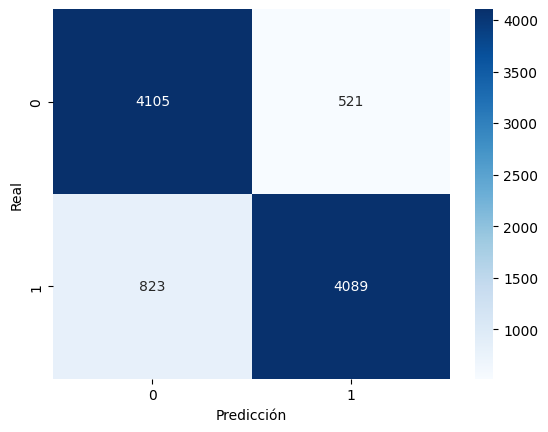

In [15]:
# Evaluation of the model

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()


### **Marilyn Stephany Joven Fonseca**

### **Eder Leandro Carbonero Baquero**

## **Deep Learning Models**

### **Nicolas Bedoya Figueroa**

### **Daniel Escalante Perez**

#### **Utils**

In [7]:
# Function for measuring the accuracy

def get_accuracy(output, y, train_size):
    pred = torch.sigmoid(output) > 0.5  # Thresholding
    correct = pred.eq(y.bool()).sum().item()
    return correct / train_size

In [8]:
# Training function

def train(train_loader, optimizer, loss_function, model_train):
    loss = 0
    accuracy = 0
    batch_num = 0
    model_train.train()
    for x, y in train_loader:
        batch_num += 1
        output = model_train(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_accuracy(output, y, len(train_loader.dataset))
    print(f"Train Loss: {round(loss/batch_num, 5)}, Train Accuracy: {round(accuracy, 5)}")

    return loss/batch_num, accuracy

In [9]:
# Validation function

def validate(val_loader, loss_function, model_val):

    loss = 0
    accuracy = 0
    batch_num = 0

    model_val.eval()
    with torch.no_grad():
        for x, y in val_loader:
            batch_num += 1
            output = model_val(x)
            batch_loss = loss_function(output, y)

            loss += batch_loss.item()
            accuracy += get_accuracy(output, y, len(val_loader.dataset))
    print(f"Validation Loss: {round(loss/batch_num, 5)}, Validation Accuracy: {round(accuracy, 5)}")
    return loss/batch_num, accuracy

In [10]:
# Saving the best model

def save_checkpoint(model_save):
    torch.save(model_save.state_dict(), "best_model.pth")
    

In [11]:
# Loading the best model

def load_checkpoint(model_load):
    checkpoint = torch.load("best_model.pth", map_location=device)
    checkpoint = { k.replace("_orig_mod.", ""): v for k, v in checkpoint.items() }
    model_load.load_state_dict(checkpoint)
    model_load = torch.compile(model_load.to(device), backend="eager")
    model_load.eval()
    return model_load
    

In [12]:
# Loss and accuracy graphing

def loss_accuracy_graph(loss_accuracy_list):
    epochs = len(loss_accuracy_list)
    train_loss = [loss_accuracy_list[i][0] for i in range(epochs)]
    train_accuracy = [loss_accuracy_list[i][1] for i in range(epochs)]
    val_loss = [loss_accuracy_list[i][2] for i in range(epochs)]
    val_accuracy = [loss_accuracy_list[i][3] for i in range(epochs)]

    plt.plot(range(1, epochs + 1), train_loss, 'r-', label = "Training")
    plt.plot(range(1, epochs + 1), val_loss, 'b-', label = "Validation")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.show()

    plt.plot(range(1, epochs + 1), train_accuracy, 'r-', label = "Training")
    plt.plot(range(1, epochs + 1), val_accuracy, 'b-', label = "Validation")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.show()
    

In [13]:
# Training loop

def training_loop(epochs, train_loader, val_loader, optimizer, loss_function, model_train_loop):
    max_accuracy = float("-inf")
    loss_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_accuracy = train(train_loader, optimizer, loss_function, model_train_loop)
        current_loss, val_accuracy = validate(val_loader, loss_function, model_train_loop)
        loss_accuracy_list.append((train_loss, train_accuracy, current_loss, val_accuracy))
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            save_checkpoint(model_train_loop)
            print("Model saved!")
        else:
            print("Model not saved!")
    
    loss_accuracy_graph(loss_accuracy_list)

In [14]:
# Model evaluation

def evaluate_model(model_load, X_test, y_test):
    model_eval = load_checkpoint(model_load)

    with torch.no_grad():
        y_pred = model_eval(torch.tensor(X_test).float().to(device))

    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5

    print(classification_report(y_test, pred))

    conf_matrix = confusion_matrix(y_test, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

#### **BI-LSTM**

In [15]:
# Check GPU availability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [16]:
# Embedding loading
X = np.load("./embeddings_data_sequencial.npy")
X.shape

(47696, 32, 768)

In [17]:
# Labels loading
data = pd.read_csv("./balanced_data.csv")
y = data["class"].values
y.shape

(47696,)

In [18]:
# Shuffling the dataset

permutation = np.random.permutation(len(y))
y = y[permutation].reshape(-1, 1)
X = X[permutation]

In [19]:
# Calculation of the set distribution

test_size = int(y.shape[0] * 0.15)
val_size = int(y.shape[0] * 0.15)
train_size = int(y.shape[0] * 0.7)

In [20]:
# Set definition

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size : ]
y_test = y[train_size + val_size : ]

In [21]:
# Custom layer that takes the last hidden state of the sequences

class Modifier(nn.Module):
    def __init__(self):
        super().__init__()
    

    def forward(self, x):
        output = x[:,-1,:]
        
        return output

In [22]:
# Custom dataset class

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.xs = torch.tensor(x).float().to(device)
        self.ys = torch.tensor(y).float().to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

In [23]:
# Creation of the custom training and validation datasets

train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_val, y_val)

In [24]:
# Creation of the dataloaders

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = True)

In [25]:
# Loader testing

x_batch, y_batch = next(iter(train_loader))
x_batch.shape

torch.Size([32, 32, 768])

In [26]:
# Custom layer that takes the last hidden state of the sequences

class Modifier(nn.Module):
    def __init__(self):
        super().__init__()
    

    def forward(self, x):
        output = x[:,-1,:]
        
        return output

In [27]:
# Model architecture definition

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 768, hidden_size = 256, num_layers = 1, batch_first = True, bidirectional=True)
        self.dropout = nn.Dropout(p = 0.3)
        self.lstm2 = nn.LSTM(input_size = 512, hidden_size = 128, num_layers = 1, batch_first = True, bidirectional=True)
        self.modifier = Modifier()
        self.dropout2 = nn.Dropout(p = 0.3)
        
        self.linear = nn.Linear(256, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 1)
        

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out)
        lstm_out, _ = self.lstm2(x)
        x = self.modifier(lstm_out)
        x = self.dropout2(x)
        
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

model = CustomModel()

In [28]:
# Model compilation

model = torch.compile(model.to(device), backend="eager")
model

OptimizedModule(
  (_orig_mod): CustomModel(
    (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm2): LSTM(512, 128, batch_first=True, bidirectional=True)
    (modifier): Modifier()
    (dropout2): Dropout(p=0.3, inplace=False)
    (linear): Linear(in_features=256, out_features=64, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [29]:
# Loss and optimizer definition

loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

Epoch 1/200
Train Loss: 0.35935, Train Accuracy: 0.84341
Validation Loss: 0.30861, Validation Accuracy: 0.87252
Model saved!
Epoch 2/200
Train Loss: 0.29725, Train Accuracy: 0.87288
Validation Loss: 0.29606, Validation Accuracy: 0.87126
Model not saved!
Epoch 3/200
Train Loss: 0.27212, Train Accuracy: 0.88534
Validation Loss: 0.27715, Validation Accuracy: 0.88286
Model saved!
Epoch 4/200
Train Loss: 0.24642, Train Accuracy: 0.89822
Validation Loss: 0.2637, Validation Accuracy: 0.89069
Model saved!
Epoch 5/200
Train Loss: 0.21778, Train Accuracy: 0.91128
Validation Loss: 0.27756, Validation Accuracy: 0.88426
Model not saved!
Epoch 6/200
Train Loss: 0.18451, Train Accuracy: 0.92602
Validation Loss: 0.27377, Validation Accuracy: 0.88762
Model not saved!
Epoch 7/200
Train Loss: 0.14808, Train Accuracy: 0.94279
Validation Loss: 0.31842, Validation Accuracy: 0.88957
Model not saved!
Epoch 8/200
Train Loss: 0.1152, Train Accuracy: 0.9566
Validation Loss: 0.32697, Validation Accuracy: 0.88216


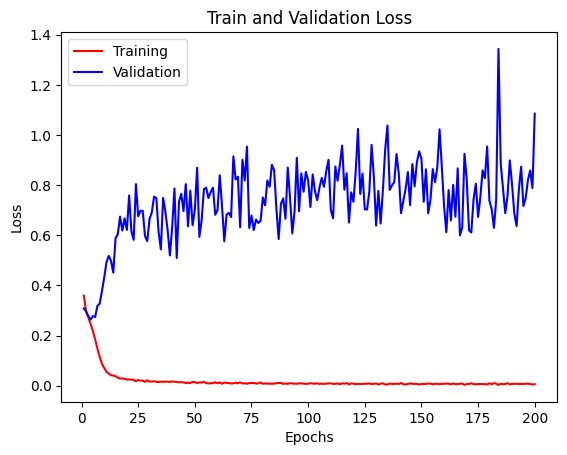

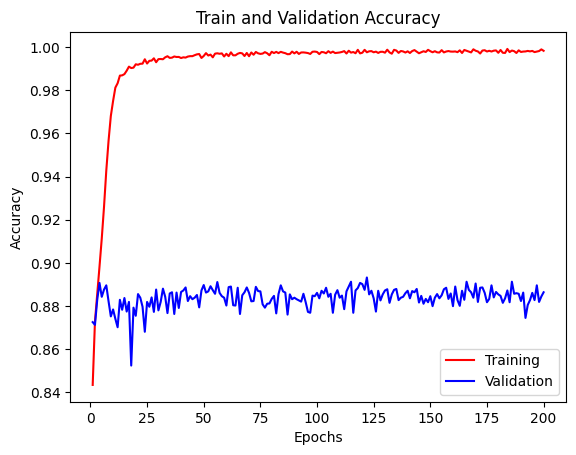

In [30]:
training_loop(200, train_loader, val_loader, optimizer, loss_function, model)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3517
           1       0.92      0.86      0.89      3638

    accuracy                           0.89      7155
   macro avg       0.89      0.89      0.89      7155
weighted avg       0.89      0.89      0.89      7155



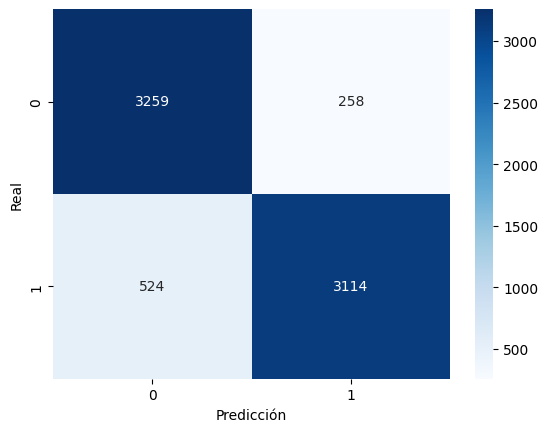

In [34]:
model_load = CustomModel()
evaluate_model(model_load, X_test, y_test)

#### **roBERTa Fine tunning with a dense classification head**

##### **Utils**

In [15]:
# Training function

def train(train_loader, optimizer, loss_function, model_train):
    loss = 0
    accuracy = 0
    batch_num = 0
    model_train.train()
    for batch in train_loader:
        batch_num += 1
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["label"].to(device).float()
        output = model_train(input_ids, attention_mask)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_accuracy(output, y, len(train_loader.dataset))
    print(f"Train Loss: {round(loss/batch_num, 5)}, Train Accuracy: {round(accuracy, 5)}")

    return loss/batch_num, accuracy

In [16]:
# Validation function

def validate(val_loader, loss_function, model_val):

    loss = 0
    accuracy = 0
    batch_num = 0

    model_val.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch_num += 1
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["label"].to(device).float()
            output = model_val(input_ids, attention_mask)
            batch_loss = loss_function(output, y)

            loss += batch_loss.item()
            accuracy += get_accuracy(output, y, len(val_loader.dataset))
    print(f"Validation Loss: {round(loss/batch_num, 5)}, Validation Accuracy: {round(accuracy, 5)}")
    return loss/batch_num, accuracy

In [17]:
# Model evaluation

def evaluate_model(model_load, test_loader):
    model_eval = load_checkpoint(model_load)
    batch = next(iter(test_loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    y = batch["label"].cpu().float().numpy()

    with torch.no_grad():
        y_pred = model_eval(input_ids, attention_mask)
    
    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5
    
    print(classification_report(y, pred))

    conf_matrix = confusion_matrix(y, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

In [18]:
# Model evaluation without loading

def evaluate_model_no_load(model_eval, test_loader):
    batch = next(iter(test_loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    y = batch["label"].cpu().float().numpy()
    model_eval.eval()
    with torch.no_grad():
        y_pred = model_eval(input_ids, attention_mask)
    
    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5
    
    print(classification_report(y, pred))

    conf_matrix = confusion_matrix(y, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

In [19]:
# Training loop

def training_loop(epochs, train_loader, val_loader, optimizer, loss_function, model_train_loop):
    max_accuracy = 0
    loss_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_accuracy = train(train_loader, optimizer, loss_function, model_train_loop)
        current_loss, val_accuracy = validate(val_loader, loss_function, model_train_loop)
        loss_accuracy_list.append((train_loss, train_accuracy, current_loss, val_accuracy))
        if max_accuracy < val_accuracy:
            max_accuracy = val_accuracy
            save_checkpoint(model_train_loop)
            print("Model saved!")
        else:
            print("Model not saved!")
    
    loss_accuracy_graph(loss_accuracy_list)

##### **Implementation**

In [20]:
# Setting the device to use GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [21]:
# Loading the data

data = pd.read_csv('balanced_data.csv')
X = data['tweet'].astype(str).values
y = data['class'].values

In [22]:
# Shuffling the dataset

permutation = np.random.permutation(len(y))
y = y[permutation].reshape(-1, 1)
X = X[permutation].tolist()

In [23]:
# Calculation of the set distribution

test_size = int(y.shape[0] * 0.15)
val_size = int(y.shape[0] * 0.15)
train_size = int(y.shape[0] * 0.7)

In [24]:
# Set definition

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size : ]
y_test = y[train_size + val_size : ]

In [25]:
# Custom dataset class

class CustomDatasetText(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return  {
            "input_ids": encoding["input_ids"].squeeze(0),         # shape: (seq_len)
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

In [26]:
# Tokenizer and dataset definitions

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
train_set = CustomDatasetText(X_train, y_train, tokenizer, 32)
val_set = CustomDatasetText(X_val, y_val, tokenizer, 32)
test_set = CustomDatasetText(X_test, y_test, tokenizer, 32)

In [27]:
# Creation of the dataloaders

train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_set, batch_size = len(test_set), shuffle = False)

In [28]:
# BERT layer in our custom fine-tuned model

class BERTLayer(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        for param in self.roberta.parameters():
            param.requires_grad = False

    def activate_grad(self):
        for param in self.roberta.parameters():
            param.requires_grad = True

    def deactivate_grad(self):
        for param in self.roberta.parameters():
            param.requires_grad = False

    def forward(self,input_ids, attention_mask):
        outputs = self.roberta(input_ids= input_ids, attention_mask= attention_mask)
        return outputs.last_hidden_state[:,0,:]

In [29]:
# Model architecture definition

class ClassificationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.3)
        self.linear2 = nn.Linear(256, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p = 0.2)
        self.linear3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        
        return x


In [30]:
# Custom model definition

class CustomModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = BERTLayer(model_name)
        self.head = ClassificationHead()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = self.head(x)
        return x

In [31]:
# Model instanciation

model_name = "cardiffnlp/twitter-roberta-base"
model = CustomModel(model_name)
model = torch.compile(model.to(device), backend="eager")
model

OptimizedModule(
  (_orig_mod): CustomModel(
    (bert): BERTLayer(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (out

In [32]:
# Loss and optimizer definition

loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3456
         1.0       0.52      1.00      0.68      3699

    accuracy                           0.52      7155
   macro avg       0.26      0.50      0.34      7155
weighted avg       0.27      0.52      0.35      7155



/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

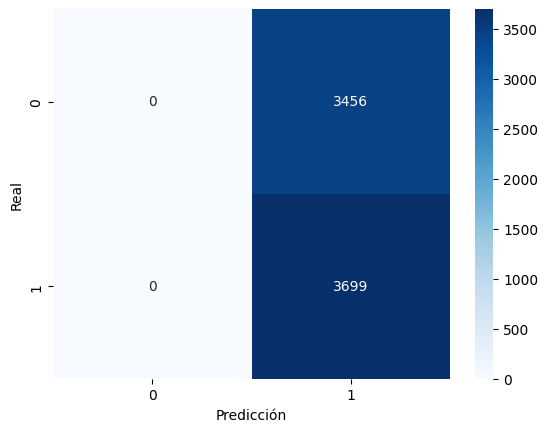

In [33]:
evaluate_model_no_load(model, test_loader)

Epoch 1/150
Train Loss: 0.40697, Train Accuracy: 0.82212
Validation Loss: 0.33714, Validation Accuracy: 0.86078
Model saved!
Epoch 2/150
Train Loss: 0.36679, Train Accuracy: 0.83892
Validation Loss: 0.32431, Validation Accuracy: 0.86148
Model saved!
Epoch 3/150
Train Loss: 0.36054, Train Accuracy: 0.8435
Validation Loss: 0.32424, Validation Accuracy: 0.85966
Model not saved!
Epoch 4/150
Train Loss: 0.35597, Train Accuracy: 0.8432
Validation Loss: 0.32318, Validation Accuracy: 0.86315
Model saved!
Epoch 5/150
Train Loss: 0.35366, Train Accuracy: 0.84233
Validation Loss: 0.33052, Validation Accuracy: 0.86287
Model not saved!
Epoch 6/150
Train Loss: 0.35054, Train Accuracy: 0.84641
Validation Loss: 0.31748, Validation Accuracy: 0.86259
Model not saved!
Epoch 7/150
Train Loss: 0.35263, Train Accuracy: 0.84659
Validation Loss: 0.31766, Validation Accuracy: 0.86497
Model saved!
Epoch 8/150
Train Loss: 0.34678, Train Accuracy: 0.85006
Validation Loss: 0.31613, Validation Accuracy: 0.86623
Mod

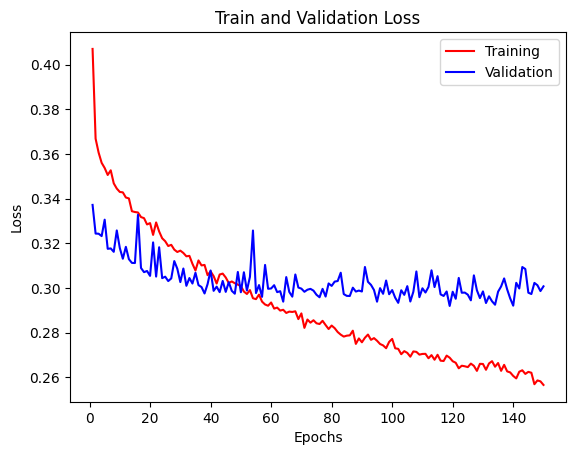

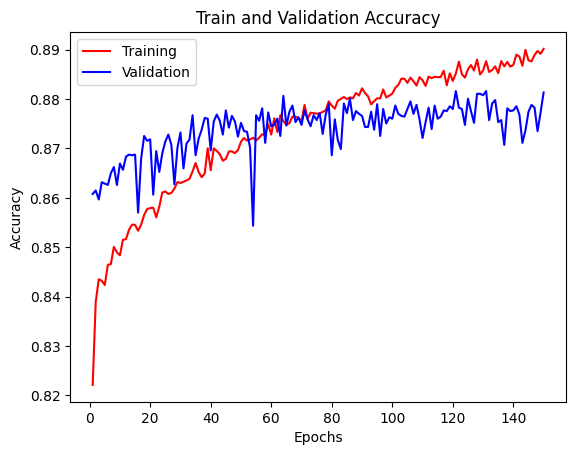

In [34]:
training_loop(150, train_loader, val_loader, optimizer, loss_function, model)

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      3456
         1.0       0.95      0.87      0.91      3699

    accuracy                           0.91      7155
   macro avg       0.91      0.91      0.91      7155
weighted avg       0.91      0.91      0.91      7155



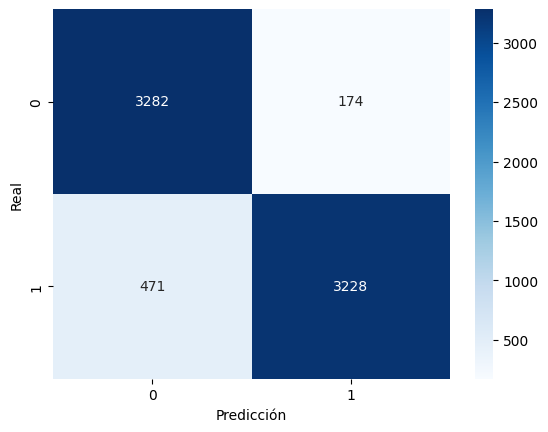

In [34]:
model_load = CustomModel(model_name)
evaluate_model(model_load, test_loader)

In [35]:
# Unfreezing the model's weights

model_load.bert.activate_grad()
optimizer = Adam(model_load.parameters(), lr=.000001)

Epoch 1/100
Train Loss: 0.27364, Train Accuracy: 0.88693
Validation Loss: 0.20949, Validation Accuracy: 0.91585
Model saved!
Epoch 2/100
Train Loss: 0.25419, Train Accuracy: 0.89343
Validation Loss: 0.20928, Validation Accuracy: 0.91529
Model not saved!
Epoch 3/100
Train Loss: 0.24473, Train Accuracy: 0.89652
Validation Loss: 0.20729, Validation Accuracy: 0.91683
Model saved!
Epoch 4/100
Train Loss: 0.23363, Train Accuracy: 0.90185
Validation Loss: 0.20665, Validation Accuracy: 0.91753
Model saved!
Epoch 5/100
Train Loss: 0.22935, Train Accuracy: 0.90365
Validation Loss: 0.20885, Validation Accuracy: 0.91487
Model not saved!
Epoch 6/100
Train Loss: 0.22143, Train Accuracy: 0.90742
Validation Loss: 0.203, Validation Accuracy: 0.91823
Model saved!
Epoch 7/100
Train Loss: 0.21557, Train Accuracy: 0.91068
Validation Loss: 0.20263, Validation Accuracy: 0.91837
Model saved!
Epoch 8/100
Train Loss: 0.20853, Train Accuracy: 0.91248
Validation Loss: 0.20202, Validation Accuracy: 0.91963
Model s

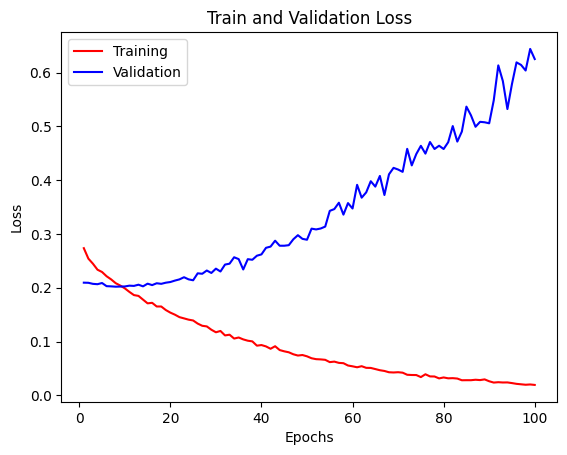

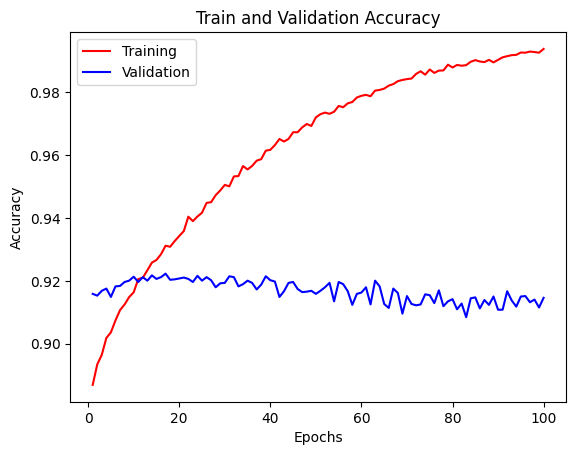

In [36]:
training_loop(100, train_loader, val_loader, optimizer, loss_function, model_load)

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      3456
         1.0       0.95      0.89      0.92      3699

    accuracy                           0.92      7155
   macro avg       0.92      0.92      0.92      7155
weighted avg       0.92      0.92      0.92      7155



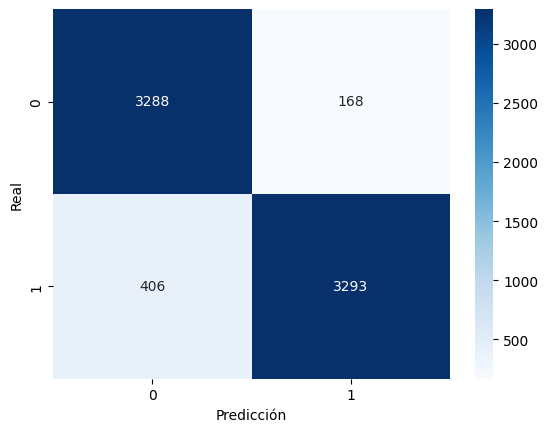

In [37]:
model_load = CustomModel(model_name)
evaluate_model(model_load, test_loader)

### **Marilyn Stephany Joven Fonseca**

### **Eder Leandro Carbonero Baquero**